### Main Analysis

##### Look at time trends and analyze various metrics of perforamance and strategy based evaluation methods 

In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [35]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

df.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,water_after_session_last_session,location,session_name,creation_time,subject_genotype,probes,results,results_location,session_time,docDB_status
0,730942,2024-09-10,181826,14.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
1,741211,2024-09-10,181707,14.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741211_2024-09-10_18-17-07,2024-09-10T18:17:07-07:00,wt/wt,[],NaN,NaN,18-17-07,1_uploaded but not processed
2,736198,2024-09-10,181446,14.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_73...,behavior_736198_2024-09-10_18-14-46,2024-09-10T18:14:46-07:00,wt/wt,[],NaN,NaN,18-14-46,1_uploaded but not processed
3,730945,2024-09-10,181112,14.0,447-2-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
4,741213,2024-09-10,180831,14.0,447-2-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741213_2024-09-10_18-08-31,2024-09-10T18:08:31-07:00,wt/wt,[],NaN,NaN,18-08-31,1_uploaded but not processed


In [36]:
# Check dimensions and content of dataframe for variables of interest: 

# Find all instances of unique subject ids
ids = df['subject_id'].unique()

# Find total stage count
num_stage = df['current_stage_actual'].unique()
stages = df['current_stage_actual']

# Find total foraging efficiency value count 
forag_eff_count = df['foraging_eff']

# Find total dates assigned per foraging efficiency score 
session_date_count = df['session_date'].unique()

# Find total number of unique tasks and labels: 
task_count = df['task'].unique()

print(f'Types of tasks: {task_count}, \n Number of unique tasks: {len(task_count)}')

print(f'\n Number of subjects: {len(ids)}')

print(f' \n Types of stages: {num_stage}, \n Number of total stages {len(stages)}')

print(f' \n Number of assigned dates {len(session_date_count)}')

print(f' \n Number of forag efficiency scores: {len(forag_eff_count)}')

Types of tasks: ['Uncoupled Baiting' 'Coupled Baiting' 'Uncoupled Without Baiting'
 'Coupled Without Baiting' 'RewardN'], 
 Number of unique tasks: 5

 Number of subjects: 183
 
 Types of stages: ['GRADUATED' 'STAGE_3' 'STAGE_1_WARMUP' 'STAGE_1' 'STAGE_FINAL' 'STAGE_2'
 'STAGE_4' nan], 
 Number of total stages 3763
 
 Number of assigned dates 283
 
 Number of forag efficiency scores: 3763


In [37]:
# Create new foraging efficiency df
fe_df = df[['subject_id', 'current_stage_actual','session_date','task','foraging_eff']]

print(fe_df.shape)
fe_df.head()

(3763, 5)


,subject_id,current_stage_actual,session_date,task,foraging_eff
0,730942,GRADUATED,2024-09-10,Uncoupled Baiting,0.761435
1,741211,GRADUATED,2024-09-10,Uncoupled Baiting,0.768945
2,736198,GRADUATED,2024-09-10,Uncoupled Baiting,0.708424
3,730945,GRADUATED,2024-09-10,Uncoupled Baiting,0.722345
4,741213,GRADUATED,2024-09-10,Uncoupled Baiting,0.740106


In [61]:
# Foraging performance df

fp_df = df[['subject_id','session_date', 'current_stage_actual', 'foraging_performance']]

fp_df = fp_df.sort_values('subject_id', ascending=False)

fp_df.head()

,subject_id,session_date,current_stage_actual,foraging_performance
108,753126,2024-09-04,STAGE_1,0.645053
138,753126,2024-09-03,STAGE_1_WARMUP,0.460859
83,753126,2024-09-05,STAGE_2,0.692634
5,753126,2024-09-10,STAGE_3,0.541744
23,753126,2024-09-09,STAGE_2,0.744223


In [39]:
# Random seed df 

rs_df = df[['subject_id', 'session_date', 'foraging_eff_random_seed', 'current_stage_actual']]

rs_df = rs_df.sort_values('subject_id', ascending=False)

rs_df.head()

,subject_id,session_date,foraging_eff_random_seed,current_stage_actual
108,753126,2024-09-04,0.670139,STAGE_1
138,753126,2024-09-03,0.588710,STAGE_1_WARMUP
83,753126,2024-09-05,0.695481,STAGE_2
5,753126,2024-09-10,0.591304,STAGE_3
23,753126,2024-09-09,0.741722,STAGE_2


In [40]:
# Plot for 1 unique subject for stage / foraging efficiency trends

subject_id = 730942

# Filter for selected subject id and create new dataframe for only that subject id
fe_df_filtered = fe_df[fe_df['subject_id'] == subject_id]

fe_df_filtered.head()

,subject_id,current_stage_actual,session_date,task,foraging_eff
0,730942,GRADUATED,2024-09-10,Uncoupled Baiting,0.761435
21,730942,GRADUATED,2024-09-09,Uncoupled Baiting,0.685184
49,730942,GRADUATED,2024-09-06,Uncoupled Baiting,0.811679
78,730942,GRADUATED,2024-09-05,Uncoupled Baiting,0.804588
103,730942,STAGE_FINAL,2024-09-04,Uncoupled Baiting,0.748354


##### Cumulative analysis

In [41]:
# Create design matrices for all task types 

def create_stage_arrays(df, stage_col='current_stage_actual', subject_col='subject_id', metric='foraging_eff'):
    # Get unique stages and subjects

    stages = df[stage_col].unique()
    subjects = df[subject_col].unique()

    stage_arrays = {}

    for stage in stages:
        # Filter the dataframe for the current stage
        stage_df = df[df[stage_col] == stage]
        
        # Get the max number of sessions for this stage
        max_sessions = stage_df.groupby(subject_col).size().max()
        
        # For the NaN stage
        if pd.isna(max_sessions):
            print(f"No data found for stage {stage}")
            continue
        
        max_sessions = int(max_sessions)
        
        stage_array = np.full((len(subjects), max_sessions), np.nan)
        
        # Fill the array with foraging efficiency scores
        for i, subject in enumerate(subjects):
            subject_data = stage_df[stage_df[subject_col] == subject][metric].values
            stage_array[i, :len(subject_data)] = subject_data
        
        stage_arrays[stage] = stage_array

    return stage_arrays

In [42]:
stage_arrays = create_stage_arrays(fe_df)
for stage, array in stage_arrays.items():
    print(f'Stage {stage}: Array shape: {array.shape}')

No data found for stage nan
Stage GRADUATED: Array shape: (183, 22)
Stage STAGE_3: Array shape: (183, 23)
Stage STAGE_1_WARMUP: Array shape: (183, 2)
Stage STAGE_1: Array shape: (183, 9)
Stage STAGE_FINAL: Array shape: (183, 34)
Stage STAGE_2: Array shape: (183, 14)
Stage STAGE_4: Array shape: (183, 10)


In [43]:
fp_stage_arrays = create_stage_arrays(fp_df, metric='foraging_performance')
for stage, array in fp_stage_arrays.items():
    print(f'Stage {stage}: Array shape: {array.shape}')

No data found for stage nan
Stage STAGE_1: Array shape: (183, 9)
Stage STAGE_1_WARMUP: Array shape: (183, 2)
Stage STAGE_2: Array shape: (183, 14)
Stage STAGE_3: Array shape: (183, 23)
Stage STAGE_FINAL: Array shape: (183, 34)
Stage STAGE_4: Array shape: (183, 10)
Stage GRADUATED: Array shape: (183, 22)


In [44]:
rs_stage_arrays = create_stage_arrays(rs_df, metric='foraging_eff_random_seed')
for stage, array in rs_stage_arrays.items():
    print(f'Stage {stage}: Array shape: {array.shape}')

No data found for stage nan
Stage STAGE_1: Array shape: (183, 9)
Stage STAGE_1_WARMUP: Array shape: (183, 2)
Stage STAGE_2: Array shape: (183, 14)
Stage STAGE_3: Array shape: (183, 23)
Stage STAGE_FINAL: Array shape: (183, 34)
Stage STAGE_4: Array shape: (183, 10)
Stage GRADUATED: Array shape: (183, 22)


In [45]:
# Create design matrices for all task / stage combinations


# Get unique stages, subjects, and tasks
stages = fe_df['current_stage_actual'].unique()
subjects = fe_df['subject_id'].unique()
tasks = fe_df['task'].unique()

# Initialize new dictionary 
stage_task_arrays = {}

for stage in stages:
    for task in tasks:
        # Filter the dataframe for the current stage and task
        stage_task_df = fe_df[(fe_df['current_stage_actual'] == stage) & (fe_df['task'] == task)]
        
        max_sessions = stage_task_df.groupby('subject_id').size().max()
        
        # For stages or tasks with no data
        if pd.isna(max_sessions):
            print(f"No data found for stage {stage} and task {task}")
            continue
        
        max_sessions = int(max_sessions)
        
        stage_task_array = np.full((len(subjects), max_sessions), np.nan)
        
        # Fill the array with fe scores
        for i, subject in enumerate(subjects):
            subject_data = stage_task_df[stage_task_df['subject_id'] == subject]['foraging_eff'].values
            stage_task_array[i, :len(subject_data)] = subject_data
        
        stage_task_arrays[(stage, task)] = stage_task_array

for (stage, task), array in stage_task_arrays.items():
    print(f"Stage {stage}, Task {task}: Array shape = {array.shape}")

No data found for stage GRADUATED and task Coupled Without Baiting
No data found for stage GRADUATED and task RewardN
No data found for stage STAGE_3 and task RewardN
No data found for stage STAGE_1_WARMUP and task Uncoupled Baiting
No data found for stage STAGE_1_WARMUP and task Uncoupled Without Baiting
No data found for stage STAGE_1_WARMUP and task Coupled Without Baiting
No data found for stage STAGE_1_WARMUP and task RewardN
No data found for stage STAGE_1 and task Uncoupled Baiting
No data found for stage STAGE_1 and task Uncoupled Without Baiting
No data found for stage STAGE_1 and task RewardN
No data found for stage STAGE_FINAL and task RewardN
No data found for stage STAGE_2 and task Uncoupled Baiting
No data found for stage STAGE_2 and task Uncoupled Without Baiting
No data found for stage STAGE_2 and task RewardN
No data found for stage STAGE_4 and task Coupled Baiting
No data found for stage STAGE_4 and task Coupled Without Baiting
No data found for stage STAGE_4 and task

In [46]:
# Create readable table of above data for task, stage, fe counts

count_data = []

for stage in stages:
    for task in tasks:
        # Filter the df for the current stage and task
        stage_task_df = fe_df[(fe_df['current_stage_actual'] == stage) & (fe_df['task'] == task)]
        
        # Count the number of scores for this stage and task
        count = stage_task_df['foraging_eff'].count()
        
        # Append the count to list
        count_data.append({
            'Stage': stage,
            'Task': task,
            'Count': count
        })

# Create the df from the list of count data
count_df = pd.DataFrame(count_data)

# Pivot the df to create a table with stages as rows and tasks as columns
result_table = count_df.pivot(index='Stage', columns='Task', values='Count')

result_table = result_table.fillna(0).astype(int)

# Add the total for both rows and columns
result_table.loc['Total'] = result_table.sum()
result_table['Total'] = result_table.sum(axis=1)

print(result_table)

Task            Coupled Baiting  Coupled Without Baiting  RewardN  \
Stage                                                               
NaN                           0                        0        0   
GRADUATED                    44                        0        0   
STAGE_1                     141                        1        0   
STAGE_1_WARMUP               95                        0        0   
STAGE_2                     129                      175        0   
STAGE_3                      69                      128        0   
STAGE_4                       0                        0        0   
STAGE_FINAL                 126                        1        0   
Total                       604                      305        0   

Task            Uncoupled Baiting  Uncoupled Without Baiting  Total  
Stage                                                                
NaN                             0                          0      0  
GRADUATED                     

In [47]:
# Function to adjust outliers in each stage 

def remove_outliers_n(data_dict, n):
    result = {}

    for key, array in data_dict.items():

        if isinstance(key, tuple):
            stage, task = key
        else:
            stage = key
            task = None

        # Count non-NaN values in each row
        non_nan_counts = np.sum(~np.isnan(array), axis=1)
        
        # Sort rows by their non-NaN counts
        sorted_indices = np.argsort(non_nan_counts)[::-1]
        sorted_counts = non_nan_counts[sorted_indices]
        
        # Identify the cutoff point
        if len(sorted_counts) > n:
            cutoff = sorted_counts[n]
        else:
            cutoff = sorted_counts[-1]
        
        # Create a mask for rows to keep
        keep_mask = non_nan_counts <= cutoff
        
        # Create make for rows to trim
        trim_mask = non_nan_counts > cutoff
        
        new_array = np.full((array.shape[0], cutoff), np.nan)
        
        # Fill in the rows that are kept
        new_array[keep_mask] = array[keep_mask][:, :cutoff]
        
        # Fill in the trimmed rows
        for i in np.where(trim_mask)[0]:
            non_nan_indices = np.where(~np.isnan(array[i]))[0][:cutoff]
            new_array[i, :len(non_nan_indices)] = array[i, non_nan_indices]
        
        if task is not None:
            result[(stage, task)] = new_array
        else:
            result[stage] = new_array
    
    return result


In [62]:
# Set prefrence for outlier removal 

n = 4
n1 = 1
n2 = 2

# Non-task specific dict
filtered_arrays = remove_outliers_n(stage_arrays, n)

# Task specific dict
filtered_stage_task_arrays = remove_outliers_n(stage_task_arrays, n1)

#Non-task foraging performance dict
filtered_fp_arrays = remove_outliers_n(fp_stage_arrays, n2)

# random seed dict

filtered_rs_arrays = remove_outliers_n(rs_stage_arrays, n1)

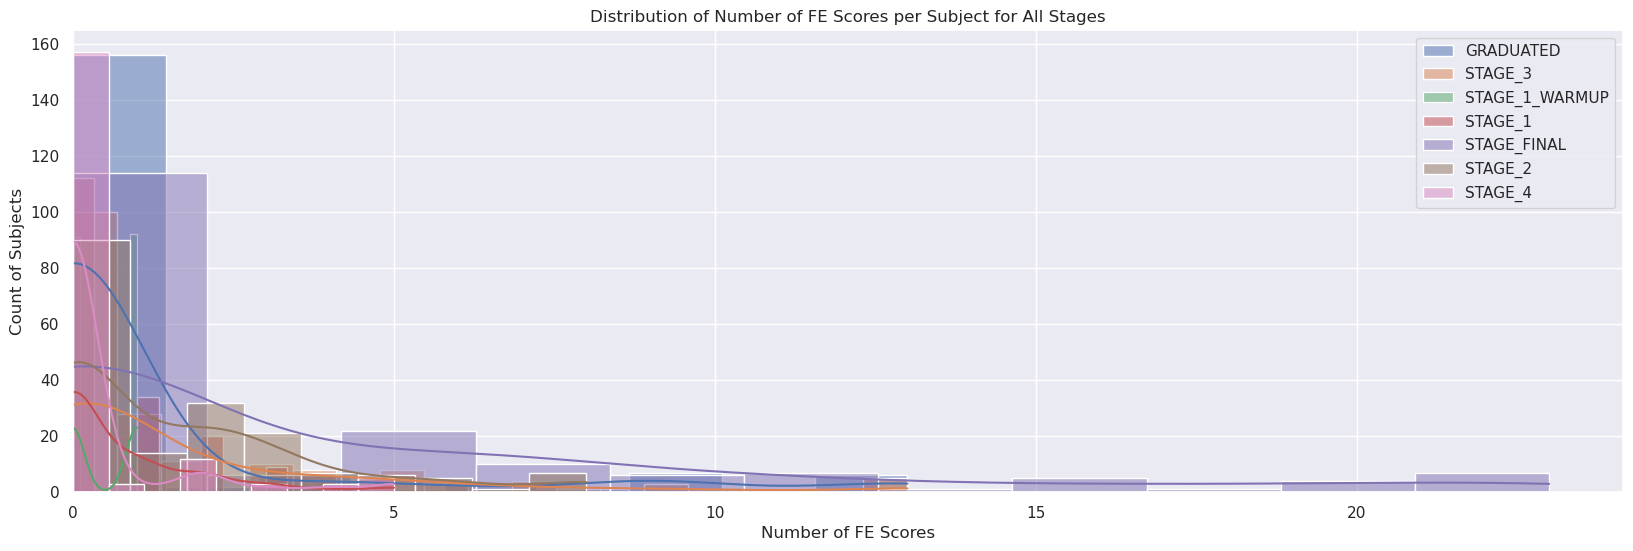

In [59]:
# Count non-NaN values for each subject after adjustment

plt.figure(figsize=(20, 6))

sns.set_theme()

for stage, array in filtered_arrays.items():
    non_nan_counts = np.sum(~np.isnan(array), axis=1)
    sns.histplot(non_nan_counts, kde=True, label=stage)

plt.title('Distribution of Number of FE Scores per Subject for All Stages')
plt.xlabel('Number of FE Scores')
plt.ylabel('Count of Subjects')
plt.xlim(left=0)
plt.legend()
plt.show()

In [50]:
def summary_statistics(data_dict):
    summary_data = []

    for key, array in data_dict.items():
        non_nan_counts = np.sum(~np.isnan(array), axis=1)
        
        Q1 = np.percentile(non_nan_counts, 5)
        Q3 = np.percentile(non_nan_counts, 95)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        outliers = non_nan_counts[(non_nan_counts > upper_bound)]
        
        if isinstance(key, tuple):
            stage, task = key
        else:
            stage, task = key, "N/A"

        summary_data.append({
            'Stage': stage,
            'Task': task,
            'Array Shape': array.shape,
            'Mean': np.mean(non_nan_counts),
            'Std Dev': np.std(non_nan_counts),
            'Min': np.min(non_nan_counts),
            'Max': np.max(non_nan_counts),
            'Outliers': len(outliers)
        })

    # Create a summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    return summary_df


In [51]:
summary_statistics(filtered_arrays)

,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,GRADUATED,N/A,"(183, 13)",1.169399,3.097459,0,13,0
1,STAGE_3,N/A,"(183, 13)",1.743169,2.966967,0,13,0
2,STAGE_1_WARMUP,N/A,"(183, 1)",0.502732,0.499993,0,1,0
3,STAGE_1,N/A,"(183, 5)",0.754098,1.200943,0,5,0
4,STAGE_FINAL,N/A,"(183, 23)",3.836066,6.112373,0,23,0
5,STAGE_2,N/A,"(183, 8)",1.595628,2.096154,0,8,0
6,STAGE_4,N/A,"(183, 5)",0.398907,1.101117,0,5,0


In [52]:
summary_statistics(filtered_stage_task_arrays)

,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,GRADUATED,Uncoupled Baiting,"(183, 11)",0.584699,2.033110,0,11,2
1,GRADUATED,Coupled Baiting,"(183, 12)",0.207650,1.452545,0,12,4
2,GRADUATED,Uncoupled Without Baiting,"(183, 20)",0.437158,2.503579,0,20,8
3,STAGE_3,Uncoupled Baiting,"(183, 3)",0.234973,0.604610,0,3,4
4,STAGE_3,Coupled Baiting,"(183, 6)",0.284153,1.032859,0,6,2
5,STAGE_3,Uncoupled Without Baiting,"(183, 17)",0.530055,2.330113,0,17,6
6,STAGE_3,Coupled Without Baiting,"(183, 13)",0.693989,2.133346,0,13,2
7,STAGE_1_WARMUP,Coupled Baiting,"(183, 2)",0.519126,0.531433,0,2,0
8,STAGE_1,Coupled Baiting,"(183, 5)",0.748634,1.202086,0,5,0
9,STAGE_1,Coupled Without Baiting,"(183, 0)",0.000000,0.000000,0,0,0


In [53]:
# Create heatmap for example array in dictionary 

def plot_array_heatmap(array, stage):
    plt.figure(figsize=(16,5))
    plt.imshow(array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Foraging Efficiency')
    plt.title(f'Foraging Efficiency Heatmap for {stage}')
    plt.xlabel('Session Index')
    plt.ylabel('Subject Index')
    plt.ylim(bottom=125)
    plt.show()

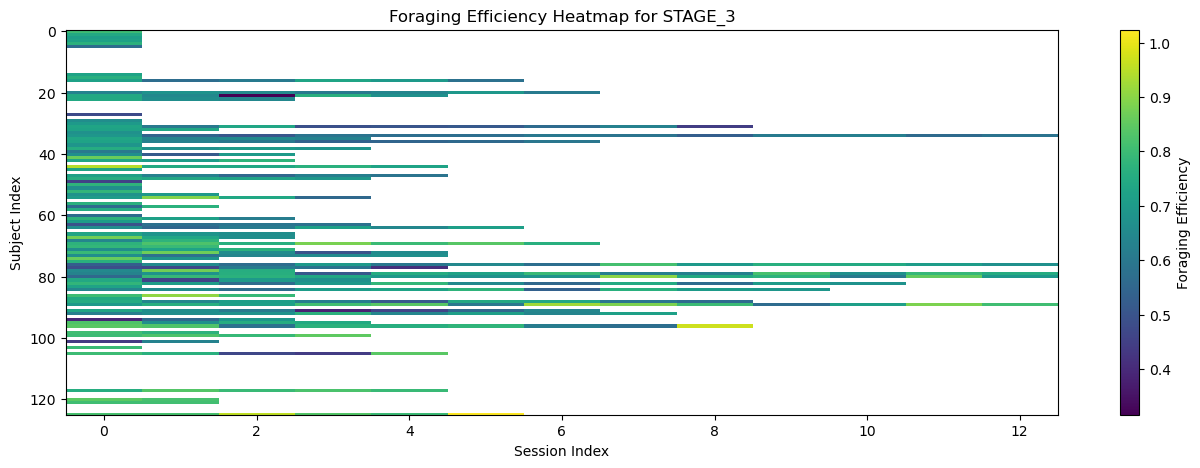

In [54]:
# Plot example array for visualization
plot_array_heatmap(filtered_arrays['STAGE_3'], 'STAGE_3')

In [55]:

def calculate_average_vectors(data_dict):
    averages = {}

    if isinstance(next(iter(data_dict.keys())), tuple):
        # Stage task dictionary
        for (stage, task), array in data_dict.items():
            if stage not in averages:
                averages[stage] = {}
            averages[stage][task] = np.nanmean(array, axis=0)
    else:
        # Stage dictionary
        for stage, array in data_dict.items():
            averages[stage] = np.nanmean(array, axis=0)

    # Find the average vectors
    for stage, value in averages.items():
        print(f"\nAverage foraging efficiency for stage {stage}:")
        if isinstance(value, dict):
            for task, average_vector in value.items():
                print(f" \n Task: {task}")
                print(f" \n Average vector: {average_vector}")
                print(f" \n Shape: {average_vector.shape}")
        else:
            print(f"Average vector: {value}")
            print(f"Shape: {value.shape}")

    return averages

In [56]:
stage_averages = calculate_average_vectors(filtered_arrays)
stage_task_averages = calculate_average_vectors(stage_task_arrays)


Average foraging efficiency for stage GRADUATED:
Average vector: [0.74374592 0.75717365 0.77008181 0.78134111 0.74092198 0.7182318
 0.7290697  0.76569463 0.78323345 0.74559313 0.80113646 0.72359173
 0.77962249]
Shape: (13,)

Average foraging efficiency for stage STAGE_3:
Average vector: [0.70950537 0.70064734 0.6693356  0.66531728 0.66631463 0.68652435
 0.65444517 0.71206736 0.66387157 0.70242539 0.67208542 0.75864257
 0.70102762]
Shape: (13,)

Average foraging efficiency for stage STAGE_1_WARMUP:
Average vector: [0.67517862]
Shape: (1,)

Average foraging efficiency for stage STAGE_1:
Average vector: [0.69723067 0.65326004 0.66055988 0.59127028 0.58516925]
Shape: (5,)

Average foraging efficiency for stage STAGE_FINAL:
Average vector: [0.75414797 0.72682649 0.72921487 0.73623829 0.74668073 0.74124177
 0.74572922 0.73217935 0.72386442 0.76313443 0.76979669 0.7332907
 0.74240561 0.7376977  0.72455611 0.74497687 0.72366256 0.72926771
 0.76913893 0.71555013 0.69563847 0.76317552 0.8424151

In [57]:
# Plot function for foraging efficiency over stages 


def plot_foraging_efficiency(data_dict, stage_sequence, ylabel='Foraging Efficiency'):
    is_stage_task = isinstance(next(iter(data_dict.keys())), tuple)
    
    # Choose between task/stage dictionary and stage dictionary 
    if is_stage_task:
        tasks = list(set(task for _, task in data_dict.keys()))
    else:
        tasks = ['']
    
    for task in tasks:
        data = []
        subject_data = []
        overall_session = 0

        for stage in stage_sequence:
            if is_stage_task:
                if (stage, task) in data_dict:
                    stage_data = data_dict[(stage, task)]
                else:
                    continue
            else:
                if stage in data_dict:
                    stage_data = data_dict[stage]
                else:
                    continue

            num_sessions = stage_data.shape[1]
            num_subjects = stage_data.shape[0]
            
            for session in range(num_sessions):
                session_data = stage_data[:, session]
                mean = np.nanmean(session_data)
                std = np.nanstd(session_data)
                
                data.append({
                    'Stage': stage,
                    'Session': overall_session,
                    'Stage Session': session,
                    'Mean': mean,
                    'Std': std
                })
                
                for subject in range(num_subjects):
                    subject_data.append({
                        'Stage': stage,
                        'Session': overall_session,
                        'Stage Session': session,
                        'Subject': subject,
                        'Score': stage_data[subject, session]
                    })

                overall_session += 1

        stage_plot_df = pd.DataFrame(data)
        subject_plot_df = pd.DataFrame(subject_data)

        plt.figure(figsize=(20, 6))

        sns.scatterplot(x='Session', y='Score', data=subject_plot_df, alpha=0.2, color='grey', legend=False)
        sns.lineplot(x='Session', y='Mean', data=stage_plot_df)

        plt.fill_between(stage_plot_df['Session'], 
                        stage_plot_df['Mean'] - stage_plot_df['Std'], 
                        stage_plot_df['Mean'] + stage_plot_df['Std'], 
                        alpha=0.2, color='b')

        plt.xlabel('Session (across all stages)', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)

        stage_boundaries = [stage_plot_df[stage_plot_df['Stage'] == stage]['Session'].min() 
                            for stage in stage_sequence if stage in stage_plot_df['Stage'].unique()]
        for boundary in stage_boundaries[1:]:
            plt.axvline(x=boundary - 0.5, color='b', linestyle='--', alpha=0.5)

        xticks = []
        xticklabels = []
        for i, stage in enumerate(stage_sequence):
            if stage in stage_plot_df['Stage'].unique():
                stage_sessions = stage_plot_df[stage_plot_df['Stage'] == stage]['Session']
                stage_start = stage_sessions.min()
                stage_end = stage_sessions.max()
                stage_ticks = range(int(stage_start), int(stage_end) + 1, 4)
                xticks.extend(stage_ticks)
                xticklabels.extend(range(0, (len(stage_ticks) - 1) * 4 + 1, 4))

                mid_point = (stage_start + stage_end) / 2
                plt.text(mid_point, plt.ylim()[1], stage, horizontalalignment='center', verticalalignment='bottom')

        plt.xticks(xticks, xticklabels)
        plt.xticks(ha='right')

        plt.plot([], [], color='grey', alpha=0.2, linewidth=0, marker='o', markersize=10, label='Subject Scores')

        if is_stage_task:
            plt.plot([], [], color='blue', linewidth=2, label=f'{task} Mean Score')
        else:
            plt.plot([], [], color='blue', linewidth=2, label='All Task Mean Score')
        
        plt.fill_between([], [], alpha=0.2, label='Standard Deviation')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print(f"\nStatistics for {'Task: ' + task if is_stage_task else 'All Tasks'}:")
        for stage in stage_sequence:
            if stage in stage_plot_df['Stage'].unique():
                stage_data = stage_plot_df[stage_plot_df['Stage'] == stage]
                print(f'\n{stage}:')
                print(f'Number of Sessions: {len(stage_data)}')
                print(f"Mean {ylabel}: {stage_data['Mean'].mean():.2f}")
                print(f"Standard deviation: {stage_data['Mean'].std():.2f}")
                print(f"Min efficiency: {stage_data['Mean'].min():.2f}")
                print(f"Max efficiency: {stage_data['Mean'].max():.2f}")

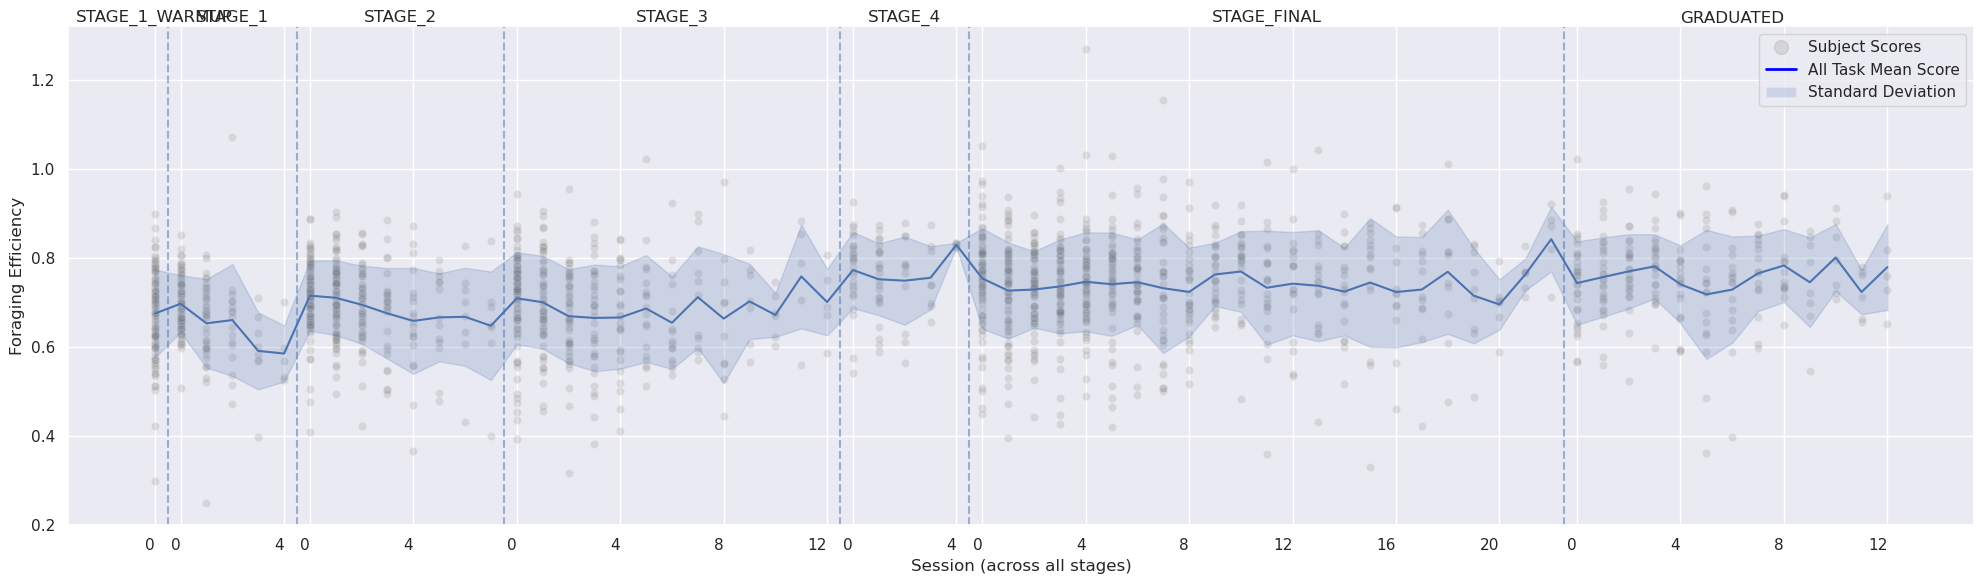


Statistics for All Tasks:

STAGE_1_WARMUP:
Number of Sessions: 1
Mean Foraging Efficiency: 0.68
Standard deviation: nan
Min efficiency: 0.68
Max efficiency: 0.68

STAGE_1:
Number of Sessions: 5
Mean Foraging Efficiency: 0.64
Standard deviation: 0.05
Min efficiency: 0.59
Max efficiency: 0.70

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.68
Standard deviation: 0.02
Min efficiency: 0.65
Max efficiency: 0.72

STAGE_3:
Number of Sessions: 13
Mean Foraging Efficiency: 0.69
Standard deviation: 0.03
Min efficiency: 0.65
Max efficiency: 0.76

STAGE_4:
Number of Sessions: 5
Mean Foraging Efficiency: 0.77
Standard deviation: 0.03
Min efficiency: 0.75
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 23
Mean Foraging Efficiency: 0.74
Standard deviation: 0.03
Min efficiency: 0.70
Max efficiency: 0.84

GRADUATED:
Number of Sessions: 13
Mean Foraging Efficiency: 0.76
Standard deviation: 0.03
Min efficiency: 0.72
Max efficiency: 0.80


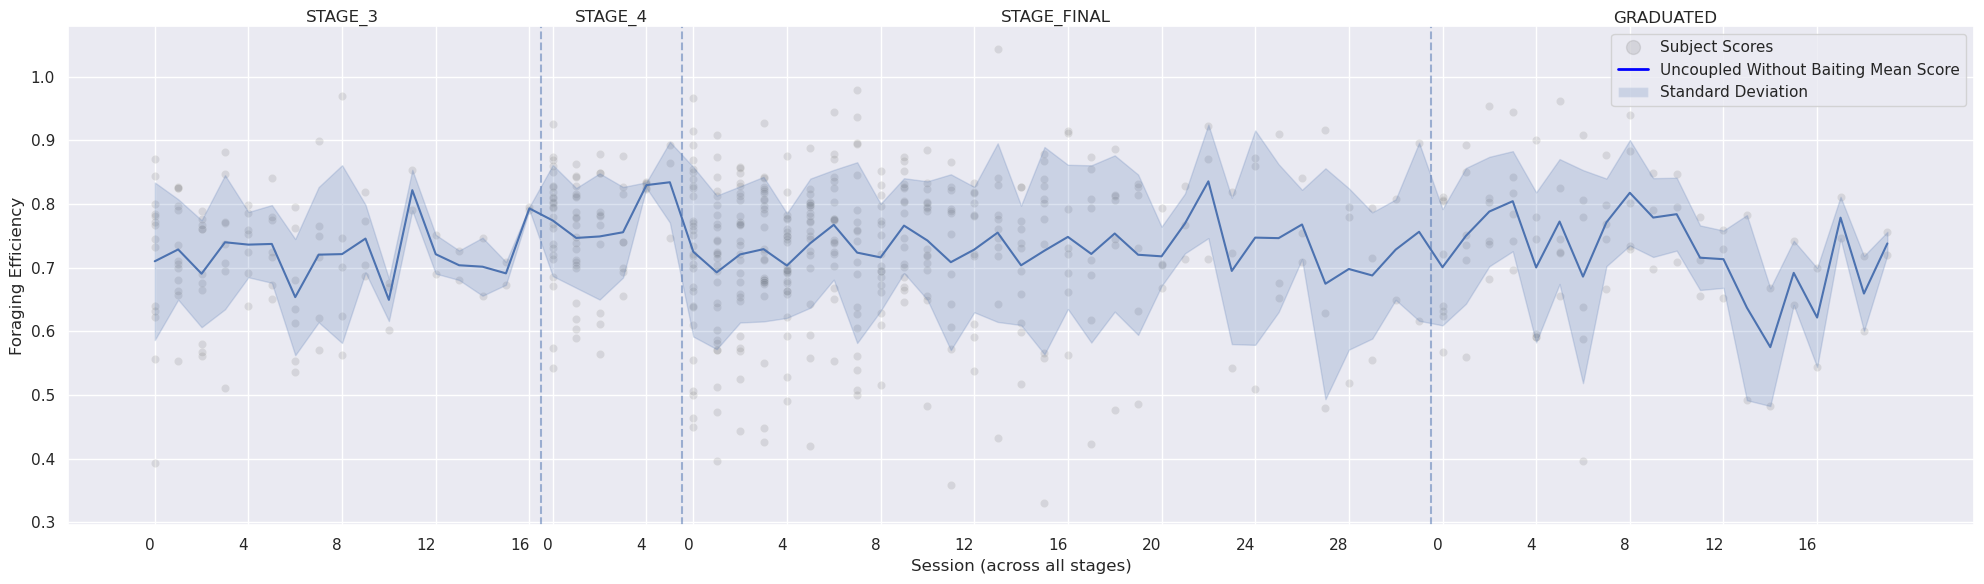


Statistics for Task: Uncoupled Without Baiting:

STAGE_3:
Number of Sessions: 17
Mean Foraging Efficiency: 0.72
Standard deviation: 0.04
Min efficiency: 0.65
Max efficiency: 0.82

STAGE_4:
Number of Sessions: 6
Mean Foraging Efficiency: 0.78
Standard deviation: 0.04
Min efficiency: 0.75
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 32
Mean Foraging Efficiency: 0.73
Standard deviation: 0.03
Min efficiency: 0.67
Max efficiency: 0.84

GRADUATED:
Number of Sessions: 20
Mean Foraging Efficiency: 0.72
Standard deviation: 0.07
Min efficiency: 0.58
Max efficiency: 0.82


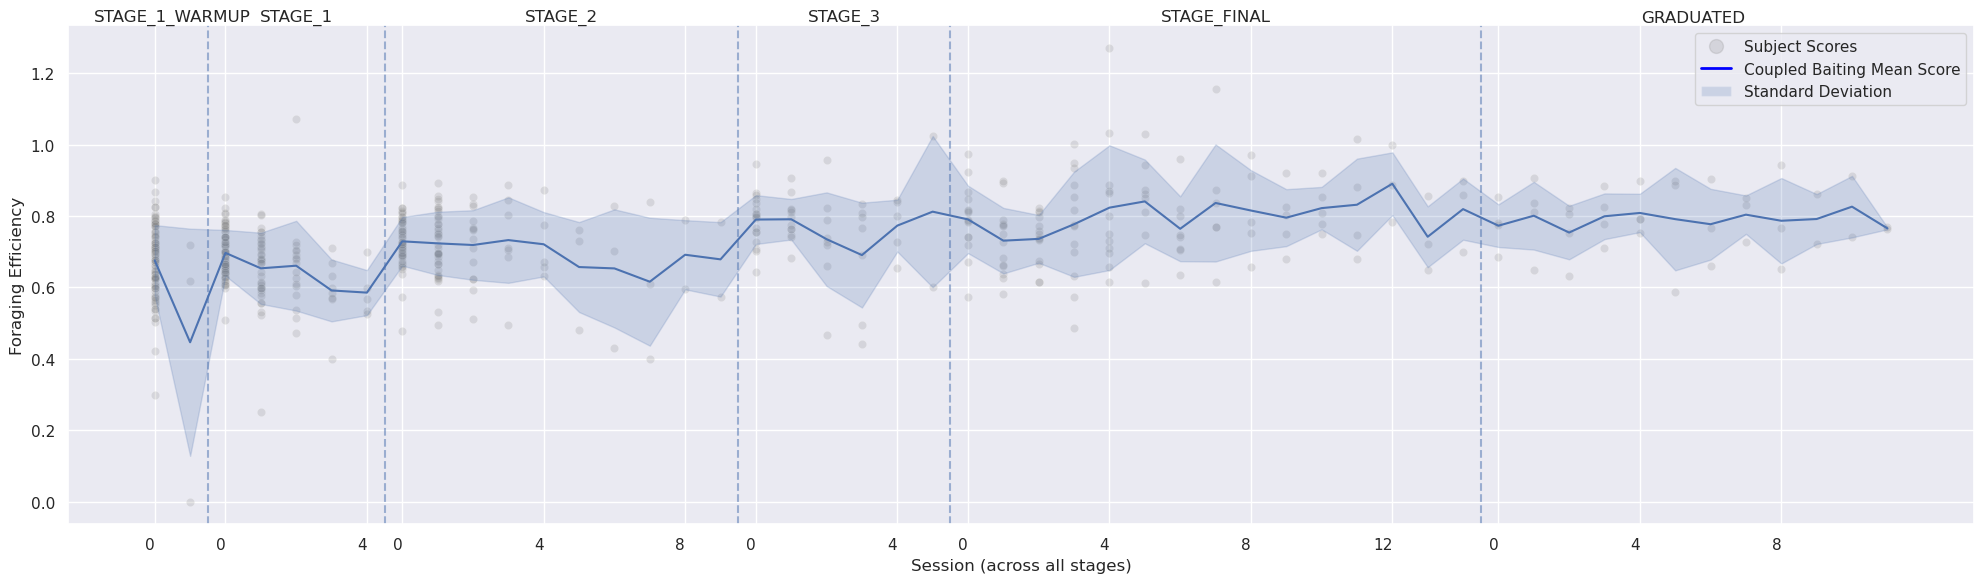


Statistics for Task: Coupled Baiting:

STAGE_1_WARMUP:
Number of Sessions: 2
Mean Foraging Efficiency: 0.56
Standard deviation: 0.16
Min efficiency: 0.45
Max efficiency: 0.68

STAGE_1:
Number of Sessions: 5
Mean Foraging Efficiency: 0.64
Standard deviation: 0.05
Min efficiency: 0.59
Max efficiency: 0.70

STAGE_2:
Number of Sessions: 10
Mean Foraging Efficiency: 0.69
Standard deviation: 0.04
Min efficiency: 0.62
Max efficiency: 0.73

STAGE_3:
Number of Sessions: 6
Mean Foraging Efficiency: 0.77
Standard deviation: 0.04
Min efficiency: 0.69
Max efficiency: 0.81

STAGE_FINAL:
Number of Sessions: 15
Mean Foraging Efficiency: 0.80
Standard deviation: 0.04
Min efficiency: 0.73
Max efficiency: 0.89

GRADUATED:
Number of Sessions: 12
Mean Foraging Efficiency: 0.79
Standard deviation: 0.02
Min efficiency: 0.75
Max efficiency: 0.83


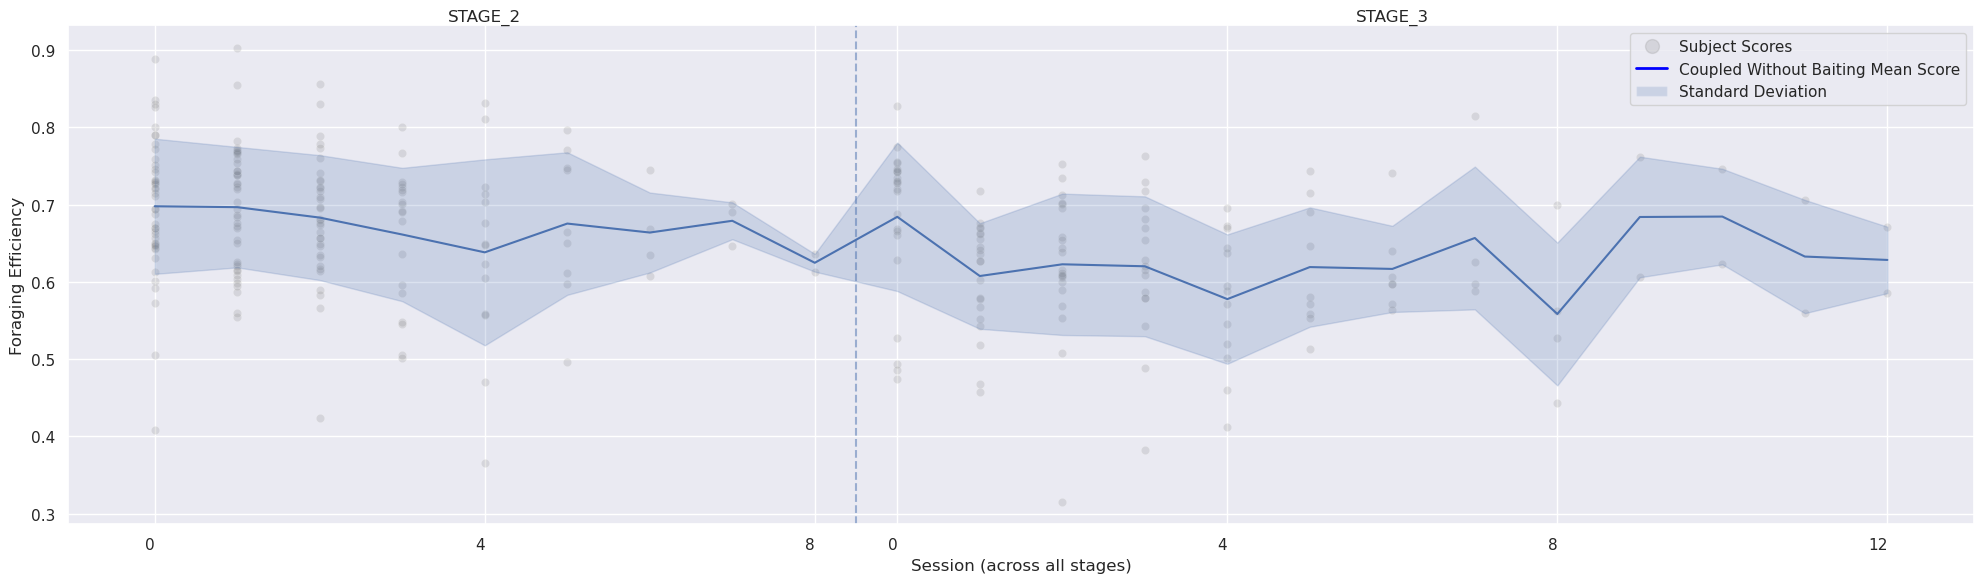


Statistics for Task: Coupled Without Baiting:

STAGE_2:
Number of Sessions: 9
Mean Foraging Efficiency: 0.67
Standard deviation: 0.02
Min efficiency: 0.62
Max efficiency: 0.70

STAGE_3:
Number of Sessions: 13
Mean Foraging Efficiency: 0.63
Standard deviation: 0.04
Min efficiency: 0.56
Max efficiency: 0.68


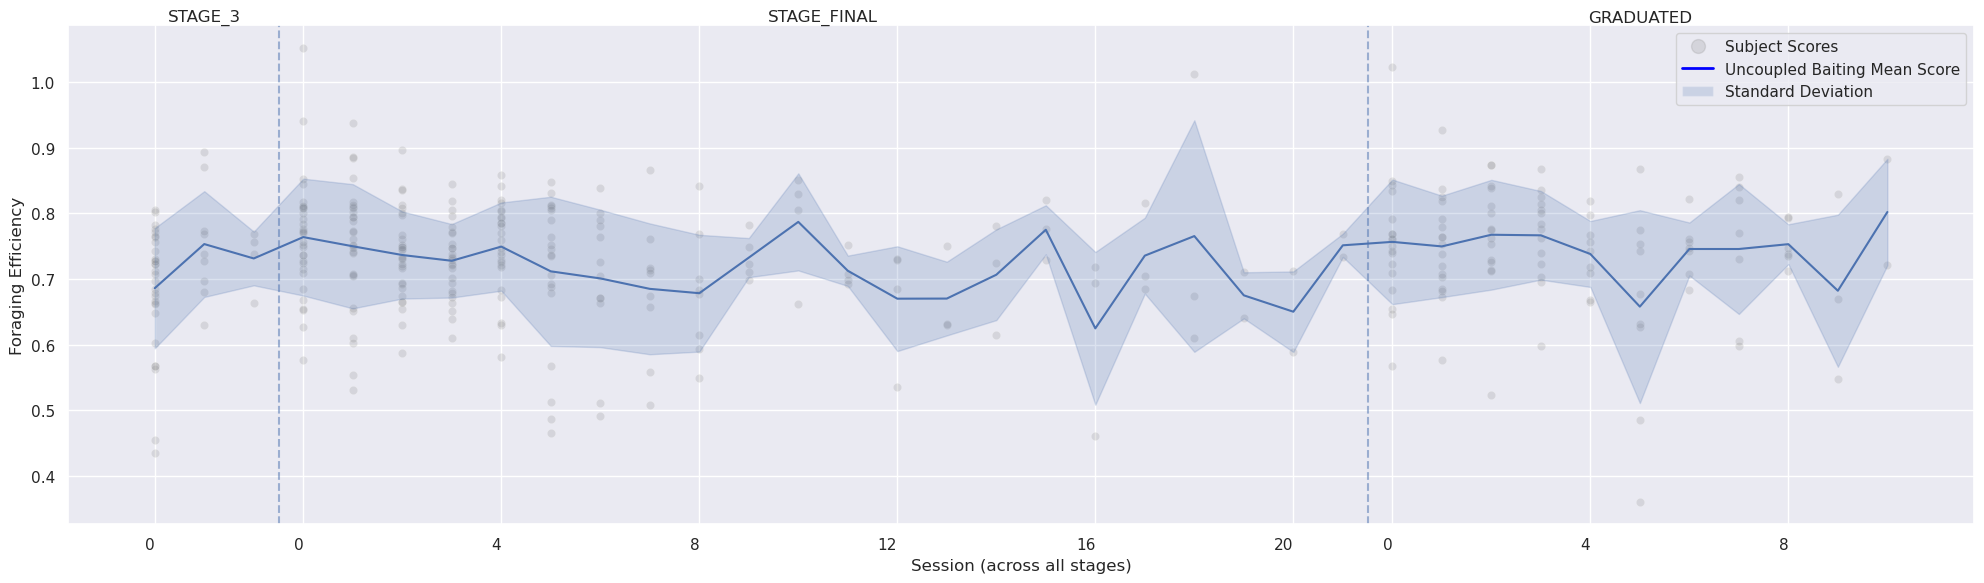


Statistics for Task: Uncoupled Baiting:

STAGE_3:
Number of Sessions: 3
Mean Foraging Efficiency: 0.72
Standard deviation: 0.03
Min efficiency: 0.69
Max efficiency: 0.75

STAGE_FINAL:
Number of Sessions: 22
Mean Foraging Efficiency: 0.72
Standard deviation: 0.04
Min efficiency: 0.62
Max efficiency: 0.79

GRADUATED:
Number of Sessions: 11
Mean Foraging Efficiency: 0.74
Standard deviation: 0.04
Min efficiency: 0.66
Max efficiency: 0.80


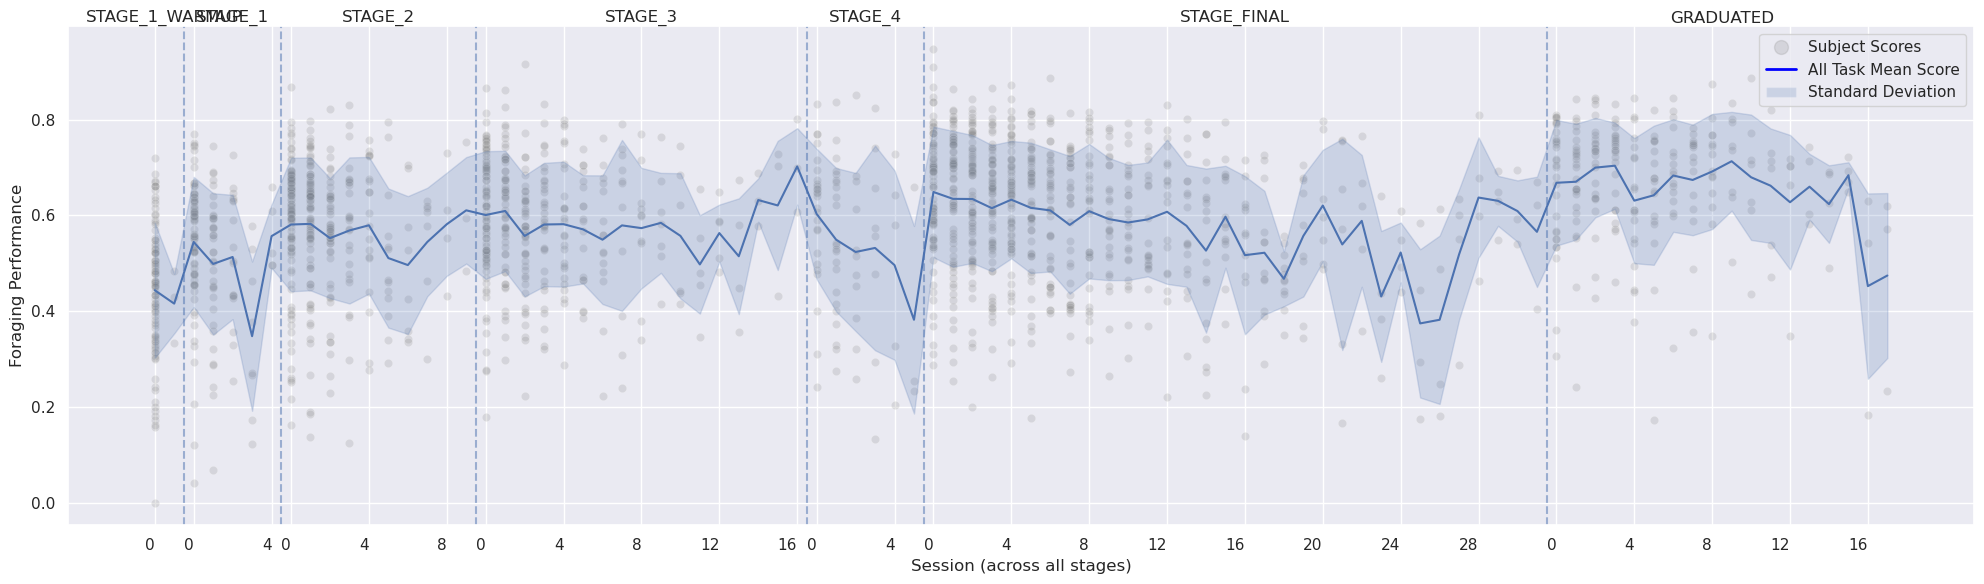


Statistics for All Tasks:

STAGE_1_WARMUP:
Number of Sessions: 2
Mean Foraging Performance: 0.43
Standard deviation: 0.02
Min efficiency: 0.42
Max efficiency: 0.44

STAGE_1:
Number of Sessions: 5
Mean Foraging Performance: 0.49
Standard deviation: 0.08
Min efficiency: 0.35
Max efficiency: 0.56

STAGE_2:
Number of Sessions: 10
Mean Foraging Performance: 0.56
Standard deviation: 0.04
Min efficiency: 0.50
Max efficiency: 0.61

STAGE_3:
Number of Sessions: 17
Mean Foraging Performance: 0.58
Standard deviation: 0.05
Min efficiency: 0.50
Max efficiency: 0.70

STAGE_4:
Number of Sessions: 6
Mean Foraging Performance: 0.51
Standard deviation: 0.07
Min efficiency: 0.38
Max efficiency: 0.60

STAGE_FINAL:
Number of Sessions: 32
Mean Foraging Performance: 0.57
Standard deviation: 0.07
Min efficiency: 0.37
Max efficiency: 0.65

GRADUATED:
Number of Sessions: 18
Mean Foraging Performance: 0.65
Standard deviation: 0.07
Min efficiency: 0.45
Max efficiency: 0.71


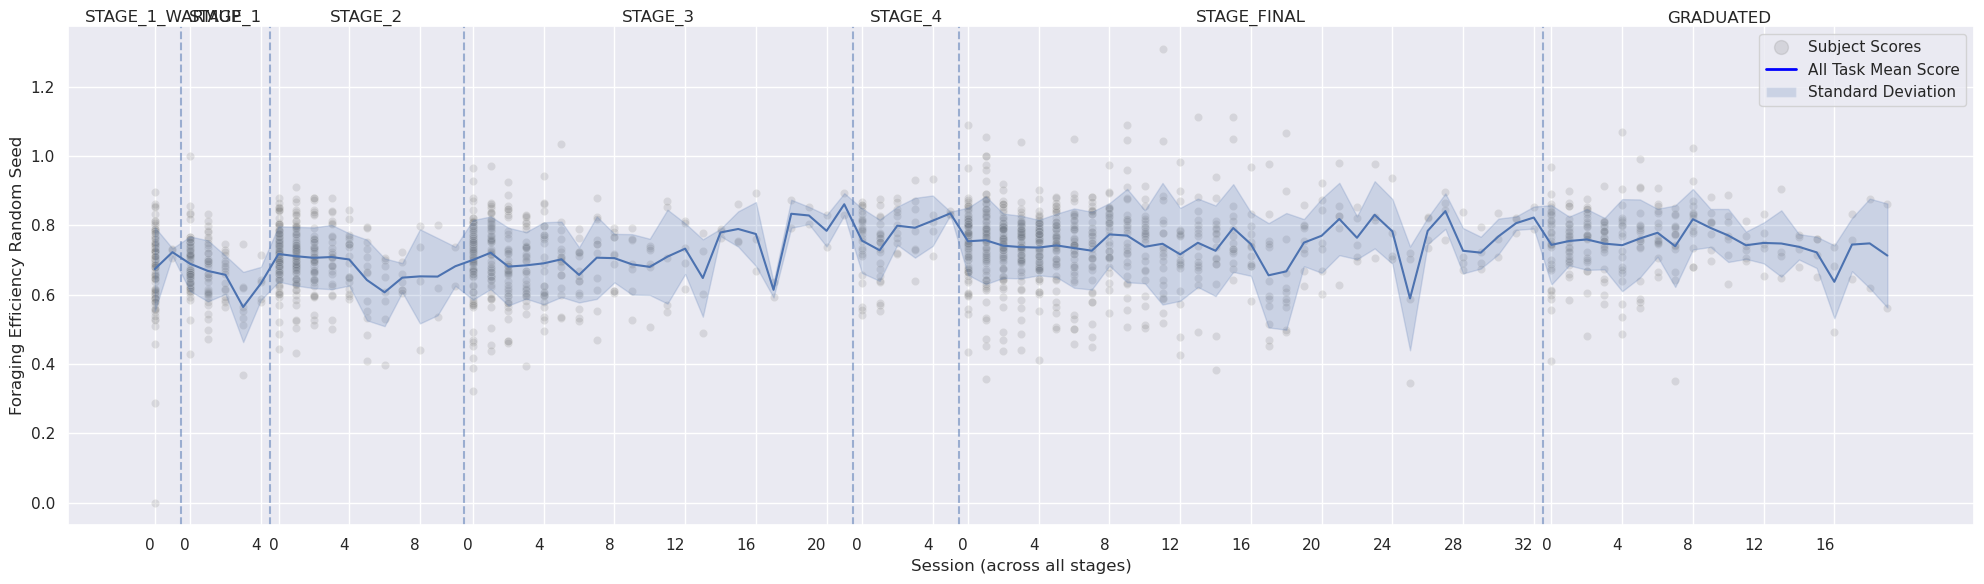


Statistics for All Tasks:

STAGE_1_WARMUP:
Number of Sessions: 2
Mean Foraging Efficiency Random Seed: 0.70
Standard deviation: 0.03
Min efficiency: 0.67
Max efficiency: 0.72

STAGE_1:
Number of Sessions: 5
Mean Foraging Efficiency Random Seed: 0.64
Standard deviation: 0.05
Min efficiency: 0.56
Max efficiency: 0.69

STAGE_2:
Number of Sessions: 11
Mean Foraging Efficiency Random Seed: 0.68
Standard deviation: 0.04
Min efficiency: 0.61
Max efficiency: 0.72

STAGE_3:
Number of Sessions: 22
Mean Foraging Efficiency Random Seed: 0.73
Standard deviation: 0.06
Min efficiency: 0.61
Max efficiency: 0.86

STAGE_4:
Number of Sessions: 6
Mean Foraging Efficiency Random Seed: 0.79
Standard deviation: 0.04
Min efficiency: 0.73
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 33
Mean Foraging Efficiency Random Seed: 0.75
Standard deviation: 0.05
Min efficiency: 0.59
Max efficiency: 0.84

GRADUATED:
Number of Sessions: 20
Mean Foraging Efficiency Random Seed: 0.75
Standard deviation: 0.03
Min 

In [63]:
stage_sequence = ['STAGE_1_WARMUP', 'STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_FINAL', 'GRADUATED']

plot_foraging_efficiency(filtered_arrays, stage_sequence)
plot_foraging_efficiency(filtered_stage_task_arrays, stage_sequence)

# Foraging Performance
plot_foraging_efficiency(filtered_fp_arrays, stage_sequence, ylabel='Foraging Performance')

# Random Seed
plot_foraging_efficiency(filtered_rs_arrays, stage_sequence, ylabel='Foraging Efficiency Random Seed')